In [1]:
!pip install openpyxl

     |████████████████████████████████| 242 kB 869 kB/s 
  Created wheel for et-xmlfile: filename=et_xmlfile-1.0.1-py3-none-any.whl size=8913 sha256=25f8dd13cfd505b648e703285e1c5e92f895ae59e8ba497cebb9f4c7c472058c
  Stored in directory: /root/.cache/pip/wheels/e2/bd/55/048b4fd505716c4c298f42ee02dffd9496bb6d212b266c7f31
Successfully built et-xmlfile


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go

from openpyxl import load_workbook
import geopandas as gpd
from descartes import PolygonPatch
import glob
import matplotlib.cm as cm
import warnings
warnings.filterwarnings('ignore')

import folium

In [3]:
wb = load_workbook('../input/gender-dataset/Data_Extract_From_Gender_Statistics _countries.xlsx')
ws = wb["Data"]
df = pd.DataFrame(ws.values)
df.columns = df.iloc[0]
df.drop([0], axis = 0, inplace=True)

exc = pd.read_csv("../input/gender-dataset/Excluded.csv")
exc.drop([14, 26, 27,44], axis = 0, inplace = True)
df['2018 [YR2018]'] = df['2018 [YR2018]'].replace('..', np.NaN)
df = df.loc[~df['Country Code'].isin(exc['Country Code'])]

In [4]:
wb = load_workbook('../input/gender-dataset/country cls.xlsx')
ws = wb.active
df_cl = pd.DataFrame(ws.values)
df_cl.columns = df_cl.iloc[0]
df_cl.drop([0], axis = 0, inplace=True)
df_cl.rename(columns={ df_cl.columns[-4]: "Income Classification",
                       df_cl.columns[0]: "Country Code"
                     }, inplace = True)
df_cl.drop(df_cl.tail(11).index,inplace=True) 

In [5]:
df_cl = df_cl[['Country Code', 'Income Classification']]
df_cl = df_cl.replace({'L' : 'Lower', 'UM': 'Upper Middle', 'H': 'High', 'LM': 'Lower Middle'})

## Scheme 1 - Challenges on Starting A New Business for Women

In [6]:
ind1 = 'Cost of business start-up procedures, female (% of GNI per capita)'
ind2 = 'Start-up procedures to register a business, female (number)'
ind3 = 'Time required to start a business, female (days)'

In [7]:
df_plot = df.loc[(df['Series Name'] == ind1) | (df['Series Name'] == ind2) | (df['Series Name'] == ind3)]
df_plot = df_plot[[ 'Country Code', 'Series Name', '2018 [YR2018]']]
df_plot = df_plot.pivot_table(values=['2018 [YR2018]'], index='Country Code', columns = ['Series Name'])
df_plot.reset_index(level=0, inplace=True)
df_plot.columns = ['Country Code', 'Cost of business start-up procedures',
                    'Start-up procedures to register a business', 'Time required to start a business']

In [8]:
df_plot_gr = df_plot.loc[df_plot['Country Code'].isin(['LIC', 'LMC', 'UMC', 'HIC'])]
custom_dict = {'LIC':0, 'LMC':1, 'UMC':2, 'HIC':3}  
df_plot_gr['rank'] = df_plot_gr['Country Code'].map(custom_dict)
df_plot_gr.sort_values(by=['rank'],inplace=True)
df_plot_gr['Country Code'] = ['Low', 'Lower Middle', 'Upper Middle', 'High']

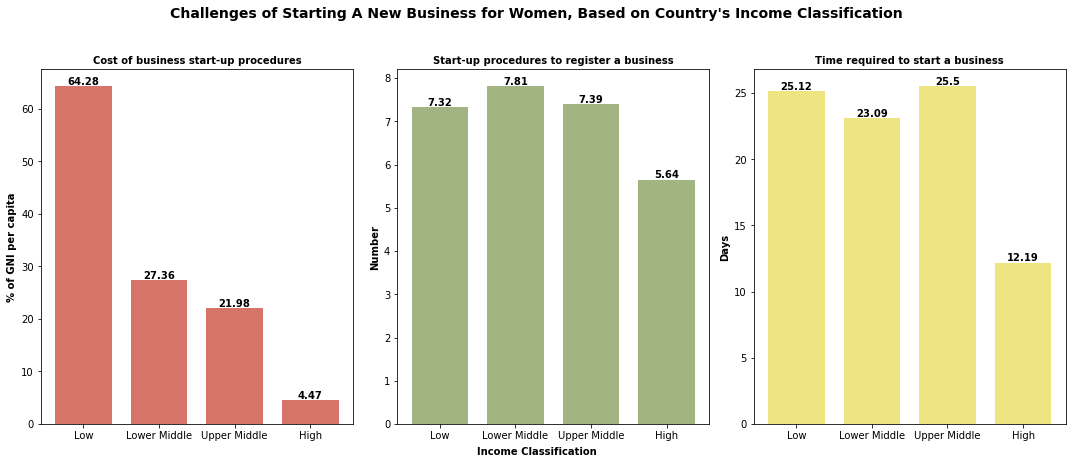

In [9]:
fig, axs = plt.subplots(1,3, figsize=(15, 6))

# pagoda = ["#965757", "#D67469", "#4E5A44", "#A1B482", '#EFE482', "#99BFCF"]
pagoda = ["#D67469", "#A1B482", '#EFE482', "#99BFCF"]
width = 0.75
ylabels = ['% of GNI per capita', 'Number', 'Days']

for i in range(3):
    ax = axs[i]    
    
    #get Top 5
    value = df_plot_gr[df_plot_gr.columns[i+1]]
    tick = df_plot_gr['Country Code']
    ax.bar(tick, value, width, color = pagoda[i])
    ax.set_title(df_plot_gr.columns[i+1], fontweight ="bold", fontsize = 10)  
    ax.set_ylabel(ylabels[i], fontweight ="bold")
    rects = ax.patches

    # Make some labels.
    labels = round(value, 2)

    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height , label, fontweight ="bold",
                ha='center', va='bottom')
    
_ = fig.text(0.5, 0, "Income Classification", ha="center", va="center", fontweight ="bold")
_ = fig.suptitle("Challenges of Starting A New Business for Women, Based on Country's Income Classification", fontweight ="bold",y=1.03, fontsize=14)
fig.tight_layout()

## Scheme 2 - How & Where Women Work

#### With Geopandas & Matplotlib

In [10]:
cols = ['Country Code', 'Country Name', '2018 [YR2018]']
df_plot = df.loc[df['Series Name'] == 'Employment to population ratio, 15+, female (%) (modeled ILO estimate)'][cols]

In [11]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

df_plot1 = df_plot.copy()
countries = df_plot1['Country Code'].unique()
check = [a for a in countries if a in sorted(world.iso_a3.unique())]
diff_c = list(set(countries) - set(check))

df_plot1 = df_plot1.loc[~df_plot1['Country Code'].isin(diff_c)]

world.loc[world['name'] == 'France', 'iso_a3'] = 'FRA'
world.loc[world['name'] == 'Norway', 'iso_a3'] = 'NOR'
world.loc[world['name'] == 'Kosovo', 'iso_a3'] = 'XKX'

world = world.merge(df_plot1, how='right', right_on = 'Country Code', left_on = 'iso_a3')

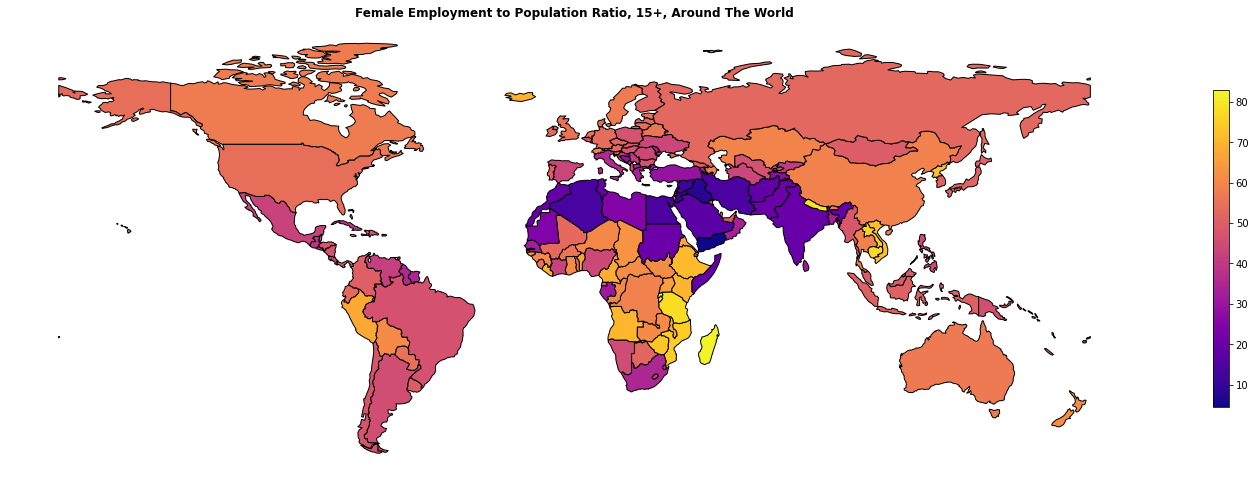

In [12]:
fig, ax = plt.subplots(1, figsize = (20,15))
world.plot(column = '2018 [YR2018]', cmap = cm.get_cmap('plasma'), ax=ax, 
             legend = True, legend_kwds={'shrink': 0.3}, edgecolor="black")
ax.axis('off')
ax.set_title('Female Employment to Population Ratio, 15+, Around The World', fontweight = 'bold')
plt.tight_layout()

In [13]:
# list(df_plot['Country Name'].unique())

#### With Folium

In [14]:
# df_plot.replace('United States', "United States of America", inplace = True)
# df_plot.replace('Tanzania', "United Republic of Tanzania", inplace = True)
# df_plot.replace('Congo, Dem. Rep.', "Democratic Republic of the Congo", inplace = True)
# df_plot.replace('Congo, Rep.', "Republic of the Congo", inplace = True)
# df_plot.replace('Lao PDR', "Laos", inplace = True)
# df_plot.replace('Syrian Arab Republic', "Syria", inplace = True)
# df_plot.replace('Serbia', "Republic of Serbia", inplace = True)

# df_plot.replace('Russian Federation', "Russia", inplace = True)
# df_plot.replace("Korea, Dem. People's Rep.", "North Korea", inplace = True)
# df_plot.replace("Korea, Rep.", "South Korea", inplace = True)

# df_plot.replace("Yemen, Rep.", "Yemen", inplace = True)
# df_plot.replace('Iran, Islamic Rep.', "Iran", inplace = True)
# df_plot.replace("Slovak Republic", "Slovakia", inplace = True)

# df_plot.replace('Venezuela, RB', "Venezuela", inplace = True)
# df_plot.replace("Egypt, Arab Rep.", "Egypt", inplace = True)
# df_plot.replace('Kyrgyz Republic', "Kyrgyzstan", inplace = True)
# df_plot.replace("Gambia, The", "Gambia", inplace = True)

# df_plot.replace('Guinea-Bissau', "Guinea Bissau", inplace = True)
# df_plot.replace("Cote d'Ivoire", "Ivory Coast", inplace = True)
# df_plot.replace('North Macedonia', "Macedonia", inplace = True)
# df_plot.replace("Eswatini", "Swaziland", inplace = True)
# df_plot.replace("Bahamas, The", "The Bahamas", inplace = True)


In [15]:
# #Creating a base map
# m = folium.Map(zoom_start=50,max_bounds=True, tiles="openstreetmap", width=700,height=500)

# #Setting up the world countries data URL
# url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
# country_shapes = f'{url}/world-countries.json'

# _ = folium.Choropleth(
#     #The GeoJSON data to represent the world country
#     geo_data=country_shapes,
#     legend_name='Female Employment Around The World (%)',
#     data=df_plot,
#     #The column aceppting list with 2 value; The country name and  the numerical value
#     columns=['Country Name', '2018 [YR2018]'],
#     key_on='feature.properties.name',
#     fill_color='PuRd',
#     nan_fill_color='white'
# ).add_to(m)

In [16]:
# m

### How & Where

In [17]:
ind1 = 'Wage and salaried workers, female (% of female employment) (modeled ILO estimate)'
ind2 = 'Employers, female (% of female employment) (modeled ILO estimate)'
ind3 = 'Self-employed, female (% of female employment) (modeled ILO estimate)'
ind4 = 'Employment in services, female (% of female employment) (modeled ILO estimate)'
ind5 = 'Employment in agriculture, female (% of female employment) (modeled ILO estimate)'
ind6 = 'Employment in industry, female (% of female employment) (modeled ILO estimate)'

In [18]:
df_plot = df.loc[df['Series Name'].isin([ind1, ind2, ind3, ind4, ind5, ind6])]
df_plot = df_plot[[ 'Country Code', 'Series Name', '2018 [YR2018]', 'Country Name']]
df_plot = df_plot.pivot_table(values=['2018 [YR2018]'], index=['Country Code', 'Country Name'], columns = ['Series Name'])
df_plot.reset_index(level=0, inplace=True)
df_plot.columns = ['Country Code', 'Employers', 'Agriculture',
                   'Industry', 'Services',
                   'Self Employed', 'Wage & Salaried Workers']
df_plot.reset_index(level=0, inplace=True)
df_plot = (df_plot.merge(df_cl, left_on='Country Code', right_on='Country Code'))

In [19]:
dg = df_plot.groupby(['Income Classification'])['Self Employed', 'Wage & Salaried Workers'].median()
custom_dict = {'Lower':0, 'Lower Middle':1, 'Upper Middle':2, 'High':3}  
dg['rank'] = dg.index.map(custom_dict)
dg.sort_values(by=['rank'],inplace=True)

In [20]:
dh = df_plot.groupby(['Income Classification'])['Agriculture', 'Industry', 'Services'].median()
dh['rank'] = dh.index.map(custom_dict)
dh.sort_values(by=['rank'],inplace=True)

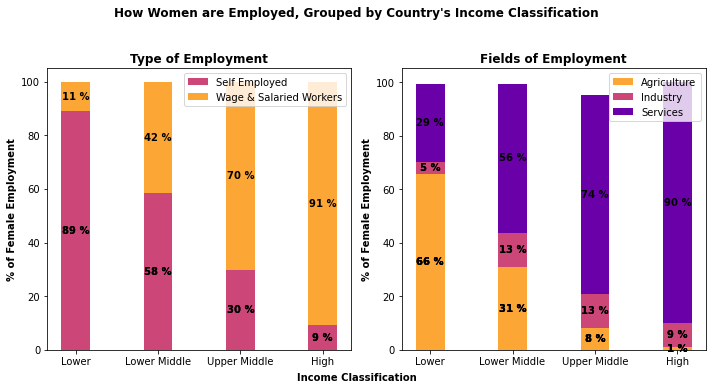

In [21]:
fig, axes = plt.subplots(1,2, figsize=(10,5))
cmap = plt.cm.get_cmap('plasma')


for c in ['Self Employed', 'Wage & Salaried Workers']:
    if c == 'Self Employed':
        axes[0].bar(dg.index, dg[c], width = 0.35, label=c, color = cmap(0.5))
    else:
        axes[0].bar(dg.index, dg[c], width = 0.35, label=c, color = cmap(0.8),
               bottom= dg['Self Employed'])
        
    for p in axes[0].patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        axes[0].text(x+width/2, 
                y+height/2, 
                '{:.0f} %'.format(height), 
                horizontalalignment='center', fontweight ="bold",
                verticalalignment='center')

axes[0].set_title('Type of Employment', fontweight ="bold")
axes[0].set_ylabel('% of Female Employment', fontweight ="bold")
axes[0].legend()
     
for c in ['Agriculture', 'Industry', 'Services']:
    if c == 'Agriculture':
        axes[1].bar(dh.index, dh[c], width = 0.35, label=c, color = cmap(0.8))
    elif c == 'Industry':
        axes[1].bar(dh.index, dh[c], width = 0.35, label=c, color = cmap(0.5),
               bottom= dh['Agriculture'])
    else:
        axes[1].bar(dh.index, dh[c], width = 0.35, label=c, color = cmap(0.2),
               bottom= dh['Agriculture'] + dh ['Industry'])
        
    for p in axes[1].patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        axes[1].text(x+width/2, 
                y+height/2, 
                '{:.0f} %'.format(height), 
                horizontalalignment='center', fontweight ="bold",
                verticalalignment='center')

axes[1].set_ylabel('% of Female Employment', fontweight ="bold")
axes[1].set_title('Fields of Employment', fontweight ="bold")
axes[1].legend()    

_ = fig.text(0.5, 0, "Income Classification", ha="center", va="center", fontweight ="bold")
_ = fig.suptitle("How Women are Employed, Grouped by Country's Income Classification", fontweight ="bold",y=1.03, fontsize=12)
fig.tight_layout()